In [1]:
import pandas as pd
import numpy as np
from utils import *

import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import linalg as LA
from tqdm import tqdm

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
X = pd.read_csv('data/Xtr1_mat50.csv', sep=' ', header=None)
Y = pd.read_csv('data/Ytr1.csv', sep=',', header=0)
X_t = pd.read_csv('data/Xte1_mat50.csv', sep=' ', header=None)
# Y_test = pd.read_csv('data/Yte0.csv', sep=',', header=0)
Y.columns = ["idx", "bound"]
Y = Y.drop(["idx"], axis=1)
# Y_test.columns = ["idx", "bound"]
# Y_test = Y_test.drop(["idx"], axis=1)

In [3]:
print(Y.shape)
print(X.shape)

(2000, 1)
(2000, 50)


In [5]:
from sklearn import svm

clf = svm.SVC(C=0.09) #, kernel='poly', degree=4)
X_train, Y_train, X_test, Y_test = preprocessing(X, Y)
clf.fit(X_train, Y_train['bound'])
Y_pred = clf.predict(X_test)
Y_train_pred = clf.predict(X_train)
print("accuracy for testing : {}".format(np.sum(Y_test['bound'] == Y_pred)/len(Y_test)))
print("accuracy for training : {}".format(np.sum(Y_train_pred == Y_train['bound'])/len(Y_train)))
# print(Y_train_pred.shape)

accuracy for testing : 0.475
accuracy for training : 0.529375


In [6]:
from sklearn.kernel_ridge import KernelRidge

clf = KernelRidge(alpha=.0001)
clf.fit(X_train, Y_train['bound'])
Y_pred = clf.predict(X_test) > 0.5
Y_train_pred = clf.predict(X_train) > 0.5
print("accuracy for testing : {}".format(np.sum(Y_test['bound'] == Y_pred)/len(Y_test)))
print("accuracy for training : {}".format(np.sum(Y_train_pred == Y_train['bound'])/len(Y_train)))


accuracy for testing : 0.5175
accuracy for training : 0.559375


In [7]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=5, max_depth=None, min_samples_split=10, random_state=0)
clf.fit(X_train, Y_train['bound'])
Y_pred = clf.predict(X_test)
Y_train_pred = clf.predict(X_train)
print("accuracy for testing : {}".format(np.sum(Y_test['bound'] == Y_pred)/len(Y_test)))
print("accuracy for training : {}".format(np.sum(Y_train_pred == Y_train['bound'])/len(Y_train)))


accuracy for testing : 0.5075
accuracy for training : 0.879375


In [8]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=5, learning_rate=.1, max_depth=5, random_state=0)
clf.fit(X_train, Y_train['bound'])
Y_pred = clf.predict(X_test)
Y_train_pred = clf.predict(X_train)
print("accuracy for testing : {}".format(np.sum(Y_test['bound'] == Y_pred)/len(Y_test)))
print("accuracy for training : {}".format(np.sum(Y_train_pred == Y_train['bound'])/len(Y_train)))

accuracy for testing : 0.525
accuracy for training : 0.685625


In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(40, input_dim=50, activation='sigmoid', kernel_initializer='zeros'))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# am = Adam(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train['bound'], epochs=20, batch_size=5)

# clf.fit(X_train, )
Y_pred = model.predict(X_test)>0.5
Y_train_pred = model.predict(X_train)>0.5
print("accuracy for testing : {}".format(np.sum(Y_test == Y_pred)/len(Y_test)))
print("accuracy for training : {}".format(np.sum(Y_train_pred == Y_train)/len(Y_train)))

Epoch 1/20
1600/1600 [==============================] - 1s 590us/step - loss: 0.6996 - acc: 0.5038
Epoch 2/20
1600/1600 [==============================] - 1s 323us/step - loss: 0.6945 - acc: 0.5019
Epoch 3/20
1600/1600 [==============================] - 1s 346us/step - loss: 0.6937 - acc: 0.5006
Epoch 4/20
1600/1600 [==============================] - 1s 407us/step - loss: 0.6948 - acc: 0.4825
Epoch 5/20
1600/1600 [==============================] - 1s 366us/step - loss: 0.6935 - acc: 0.4938
Epoch 6/20
1600/1600 [==============================] - 1s 332us/step - loss: 0.6938 - acc: 0.4969
Epoch 7/20
1600/1600 [==============================] - 1s 332us/step - loss: 0.6940 - acc: 0.4944
Epoch 8/20
1600/1600 [==============================] - 1s 423us/step - loss: 0.6938 - acc: 0.5150
Epoch 9/20
1600/1600 [==============================] - 1s 435us/step - loss: 0.6933 - acc: 0.4994
Epoch 10/20
1600/1600 [==============================] - 1s 457us/step - loss: 0.6934 - acc: 0.5213
Epoch 11/

In [11]:
X_train

matrix([[ 0.08695652,  0.04347826,  0.02173913, ...,  0.0326087 ,
          0.02173913,  0.        ],
        [ 0.04347826,  0.01086957,  0.        , ...,  0.        ,
          0.06521739,  0.04347826],
        [ 0.01086957,  0.02173913,  0.05434783, ...,  0.01086957,
          0.        ,  0.        ],
        ..., 
        [ 0.02173913,  0.04347826,  0.02173913, ...,  0.02173913,
          0.        ,  0.        ],
        [ 0.05434783,  0.        ,  0.05434783, ...,  0.05434783,
          0.04347826,  0.01086957],
        [ 0.02173913,  0.02173913,  0.04347826, ...,  0.02173913,
          0.0326087 ,  0.        ]])

In [12]:
Y_pred.shape

(400, 1)

Bon en fait j'ai l'impression que a marche pas de ouf cette représentation des ACTG... Faut qu'on trouve notre propre truc.


In [89]:
# Construction of the proteine

from itertools import product
from string import ascii_lowercase

# Creation of all possible combinations
dic_prot = [''.join(i) for i in product(base_azote, repeat = 3)]
nb_feat = len(dic_prot)
print(dic_prot)

['AAA', 'AAC', 'AAT', 'AAG', 'ACA', 'ACC', 'ACT', 'ACG', 'ATA', 'ATC', 'ATT', 'ATG', 'AGA', 'AGC', 'AGT', 'AGG', 'CAA', 'CAC', 'CAT', 'CAG', 'CCA', 'CCC', 'CCT', 'CCG', 'CTA', 'CTC', 'CTT', 'CTG', 'CGA', 'CGC', 'CGT', 'CGG', 'TAA', 'TAC', 'TAT', 'TAG', 'TCA', 'TCC', 'TCT', 'TCG', 'TTA', 'TTC', 'TTT', 'TTG', 'TGA', 'TGC', 'TGT', 'TGG', 'GAA', 'GAC', 'GAT', 'GAG', 'GCA', 'GCC', 'GCT', 'GCG', 'GTA', 'GTC', 'GTT', 'GTG', 'GGA', 'GGC', 'GGT', 'GGG']


In [187]:
X_raw = pd.read_csv('data/Xtr1.csv', sep=' ', header=None)
# test on one sequence
seq = X_raw[0][0]
# print(len(seq))
print(seq)
# print(Y['bound'][:10])

CGGGCCTCCTCCAGGCTCAGAATCGACCCCCCCCCATCCTGATAGACCACAACGAAAGCCGTAGCGACGGCCGCAGGAGCTGGCGCGACAGCCCAGAGCTC


In [188]:
from tqdm import tqdm

k=3

def k_spectre(seq, k=3):
    """
    Combine all the k-successive
    """
    k_seq = []
    for i in range(len(seq)-k+1):
        tmp = ''
        for j in range(k):
            tmp += seq[i+j]
        k_seq.append(tmp)
    return k_seq

init_feat = pd.DataFrame(0, index=[0], columns=dic_prot)
# init_feat.append(np.zeros(4**k))

def count_kuplet(k_seq):
    k = len(k_seq[0])
    new_feat = init_feat.copy()
    for kuplet in k_seq:
        new_feat[kuplet] += 1.
    return np.array(new_feat).reshape(4**k)

def feature_exractor(X, k=3):
    X_processed = []
    for seq in tqdm(X[0]):
        X_processed.append(count_kuplet(k_spectre(seq)))
    
    return X_processed
    
test = feature_exractor(X_raw)
print(test[:5])

# base_azote = ['A', 'C', 'T', 'G']



# print(keywords)     
    

 15%|█▍        | 298/2000 [00:14<01:24, 20.11it/s]

KeyboardInterrupt: 

In [180]:
w_value_hist = []
ac_range = []
ac_range2 = []
# for tau = 0.0001 et tol = 0.1 on obtient acc = 59.5
# for tau = [0.005, 0.01, 0.05] on obtient : [53.5, 49.5, 46.5]

taurange = [0.0001] # , 0.1, 0.15, 0.2, 0.3]

for tau in taurange:
    acc_range=[]
    it = 0
    # while(it < 20):
    # for it in tqdm(range(0)):
    X_train, Y_train, X_test, Y_test = preprocessing(X, Y)
    mu = 1.1
    w, w_hist, phi_w_hist = SVM_vector(X_train, Y_train['bound'], tau, mu, tol=0.3)
    print('etape3')
    w_value_hist.append(w)
    Y_train_predicted, acc_train = predict(w, X_train, Y_train['bound'])
    Y_predicted, acc = predict(w, X_test, Y_test['bound'])
    
    ac_range.append(acc_train)
    ac_range2.append(acc)

we want 1.0 to be less than 0.3
we want 0.9090909090909091 to be less than 0.3
we want 0.8264462809917353 to be less than 0.3
we want 0.7513148009015775 to be less than 0.3
we want 0.6830134553650704 to be less than 0.3
we want 0.6209213230591548 to be less than 0.3
we want 0.5644739300537771 to be less than 0.3
we want 0.5131581182307065 to be less than 0.3
we want 0.4665073802097331 to be less than 0.3
we want 0.42409761837248455 to be less than 0.3
we want 0.38554328942953137 to be less than 0.3
we want 0.35049389948139215 to be less than 0.3
we want 0.31863081771035645 to be less than 0.3
etape3


In [176]:
print(ac_range)

[50.0]


In [177]:
print(ac_range2)

[50.0]


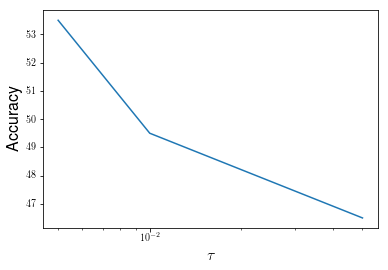

In [12]:
fig = plt.figure()
ax = fig.gca()
line1, = ax.plot(taurange, ac_range2)
ax.set_xscale('log')
ax.set_ylabel(r'Accuracy', fontsize=16)
ax.set_xlabel(r'$\tau$', fontsize=16)
plt.show()